<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/content/drive/MyDrive/Colab Notebooks/00.study/10.knou/datas


In [2]:
# !unzip -o ./mpie_30_shuffle.zip -d ./mpie_30_shuffle

In [3]:
!ls

dataCh4_7.mat		iris.zip		 mpie_30_shuffle.zip
dataCh4_7.zip		matlab_iris_shuffle.mat  number_images
digitimages_binary.zip	model.png		 results_20222205052458.pickle
iris_shuffle.mat	mpie_30_shuffle		 results_20222205052715.pickle


###Load Dataset

In [4]:
path = path_root + 'mpie_30_shuffle/'

def loadDatasetFromCSV(_datafilename, _labelfilename, label_column):
  _train_feature_csv = pd.read_csv(path + _datafilename, dtype=np.float32, header=None) # image features of train data
  _train_feature_flatten = _train_feature_csv.values.flatten()
  _train_feature_reshape = np.reshape(_train_feature_flatten, (_train_feature_csv.shape[0], 32,-1))

  _train_label_csv = pd.read_csv(path + _labelfilename, dtype=np.float32, header=None) # labels of train data
  _train_label = _train_label_csv[label_column] # get label you want

  return _train_feature_reshape, _train_label

In [5]:
import pandas as pd
import numpy as np

# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', 0)
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', 0)

train_feature_reshape.shape, train_label.shape, validation_feature_reshape.shape, validation_label.shape

((18777, 32, 32), (18777,), (5086, 32, 32), (5086,))

In [6]:
import tensorflow as tf

def preprocessDataset(features_reshape, labels, batch_size=64, shuffle_buffer_size=100):
  _batch_size = batch_size
  _shuffle_buffer_size = shuffle_buffer_size

  _features = features_reshape
  _labels = labels
  _dataset_tensors = tf.data.Dataset.from_tensor_slices((_features, _labels))

  if _shuffle_buffer_size == None:
    _dataset_tensors = _dataset_tensors.batch(_batch_size)
  else :
    _dataset_tensors = _dataset_tensors.shuffle(_shuffle_buffer_size).batch(_batch_size)

  return _dataset_tensors

In [7]:
train_dataset = preprocessDataset(train_feature_reshape, train_label)

In [8]:
# train_dataset?

In [9]:
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

###Deep CNN with BatchNormalization

In [10]:
filters = 32
_filters = filters
_min_filters = 16
_hidden_layers = int(_filters / _min_filters)
for layer in range(_hidden_layers):
  print(f'decrease : {_filters}')
  _filters = int(_filters/2)
  if _filters < _min_filters:
    break

for layer in range(_hidden_layers):
  _filters = int(_filters*2)
  if _filters > filters:
    break
  print(f'increase : {_filters}')


decrease : 32
decrease : 16
increase : 16
increase : 32


In [11]:
from tensorflow.keras import layers

category_count = train_label.unique().shape[0]
def make_cnn(filters=16, _padding='same', _kernel_initializer='he_normal', _activation='relu', _kernel_size = (3,3), _strides = (1,1), BatchNormal=True, _pool_size = (2,2)):
    model = tf.keras.Sequential()

    _filters = filters
    _min_filters = 16
    _hidden_layers = int(_filters / _min_filters)

    for layer in range(_hidden_layers):
      model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size, strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
      model.add(layers.Activation(_activation))
      if BatchNormal:
        model.add(layers.BatchNormalization())
      model.add(layers.MaxPooling2D(pool_size = _pool_size))

      _filters = int(_filters/2)
      if _filters < _min_filters:
        break

    # ?전 Layer에서 filter size 작아져 실행 않됨
    # for layer in range(_hidden_layers):
    #   _filters = int(_filters*2)
    #   if _filters > filters:
    #     break
    #   model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size, strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
    #   model.add(layers.Activation(_activation))
    #   if BatchNormal:
    #     model.add(layers.BatchNormalization())
    #   model.add(layers.MaxPooling2D(pool_size = _pool_size))

    # prior layer should be flattend to be connected to dense layers
    model.add(layers.Flatten())
    # dense layer with 50 neurons
    model.add(layers.Dense(128, activation = _activation, kernel_initializer=_kernel_initializer))
    model.add(layers.Dropout(0.5))
    # final layer with 10 neurons to classify the instances
    model.add(layers.Dense(category_count, activation = 'softmax', kernel_initializer=_kernel_initializer))

    # adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [12]:
len(list(train_dataset)) / 128

2.296875

###callback function for fit time

In [13]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

### fit model

In [14]:
_epochs = 10
# _batch_size = len(list(train_dataset)) / len(list(train_dataset))   # Just Check Model params quickly
_batch_size = len(list(train_dataset))

def model_fit(_param):
  tf.keras.backend.clear_session()

  model = make_cnn(**_param)
  history = model.fit(train_dataset, epochs=_epochs, validation_data=validation_dataset, callbacks=[time_callback], steps_per_epoch=_batch_size)
  execution_time = sum(time_callback.times)
  return model, history, execution_time, _param

### fit with multi params
filters : larger than 16

In [15]:
params = [
          {'filters':16 , '_padding':'same', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)},
          {'filters':16 , '_padding':'valid', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)},
          {'filters':16 , '_padding':'same', '_kernel_size': (5,5), '_strides': (1,1), '_pool_size': (2,2)},
          {'filters':16 , '_padding':'same', '_kernel_size': (3,3), '_strides': (3,3), '_pool_size': (2,2)},
          {'filters':16 , '_padding':'same', '_kernel_size': (3,3), '_strides': (3,3), '_pool_size': (4,4)},
          {'filters':16 , '_padding':'valid', '_kernel_size': (5,5), '_strides': (3,3), '_pool_size': (4,4)},
          {'filters':128 , '_padding':'same', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)},
          ]
results = list()          
for idx, param in enumerate(params):
  print('-'*5 +'[ '+ str(idx) + ' ]'+ '-'*5 + str(param))
  results.append(model_fit(param))


-----[ 0 ]-----{'filters': 16, '_padding': 'same', '_kernel_size': (3, 3), '_strides': (1, 1), '_pool_size': (2, 2)}
Epoch 1/10
294/294 [==============================] - 30s 97ms/step - loss: 1.3434 - accuracy: 0.6089 - val_loss: 0.6898 - val_accuracy: 0.9546
Epoch 2/10
294/294 [==============================] - 15s 53ms/step - loss: 0.3226 - accuracy: 0.8951 - val_loss: 0.0444 - val_accuracy: 0.9923
Epoch 3/10
294/294 [==============================] - 16s 53ms/step - loss: 0.1708 - accuracy: 0.9439 - val_loss: 0.0111 - val_accuracy: 0.9980
Epoch 4/10
294/294 [==============================] - 15s 53ms/step - loss: 0.1217 - accuracy: 0.9597 - val_loss: 0.0118 - val_accuracy: 0.9963
Epoch 5/10
294/294 [==============================] - 15s 52ms/step - loss: 0.1143 - accuracy: 0.9610 - val_loss: 0.0068 - val_accuracy: 0.9982
Epoch 6/10
294/294 [==============================] - 17s 57ms/step - loss: 0.0907 - accuracy: 0.9689 - val_loss: 0.0046 - val_accuracy: 0.9990
Epoch 7/10
294/294 

In [16]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y%d%m%H%M%S")
print("date and time =", dt_string)

import pickle
# save
with open(f'results_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

now = 2022-05-22 06:10:00.542251
date and time = 20222205061000
INFO:tensorflow:Assets written to: ram://5f5978d9-f31c-494b-9993-9957de989d4c/assets
INFO:tensorflow:Assets written to: ram://b974713c-208b-4ade-ac36-cc23cba57e07/assets
INFO:tensorflow:Assets written to: ram://68bd79e6-dfb7-421b-a6e2-45236fe31b58/assets
INFO:tensorflow:Assets written to: ram://ca19397d-bec2-4bae-b4ca-0cde13eae228/assets
INFO:tensorflow:Assets written to: ram://58bdb640-69de-4ab6-92f5-d802b11093fe/assets
INFO:tensorflow:Assets written to: ram://236ecc7d-9e90-485c-ac67-e95b5551ce05/assets
INFO:tensorflow:Assets written to: ram://ada23fd4-20ca-497b-b7a4-4b56ed24b693/assets


###describe model

In [17]:
model = results[0][0]

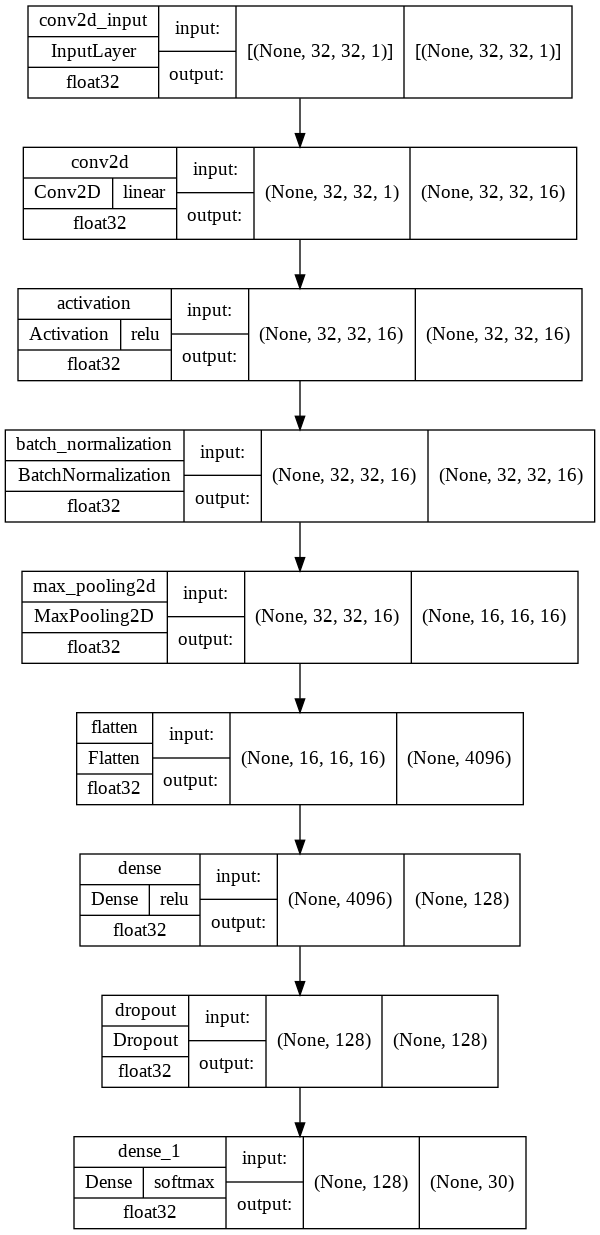

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True) #layer_range=?, 

###drawing history model

In [19]:
history = results[0][1]

In [20]:
history.history.keys(), history.params.keys()

(dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']),
 dict_keys(['verbose', 'epochs', 'steps']))

In [21]:
history.history['accuracy'][-1]

0.9775257110595703

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(_epochs)
# acc, list(epochs_range)

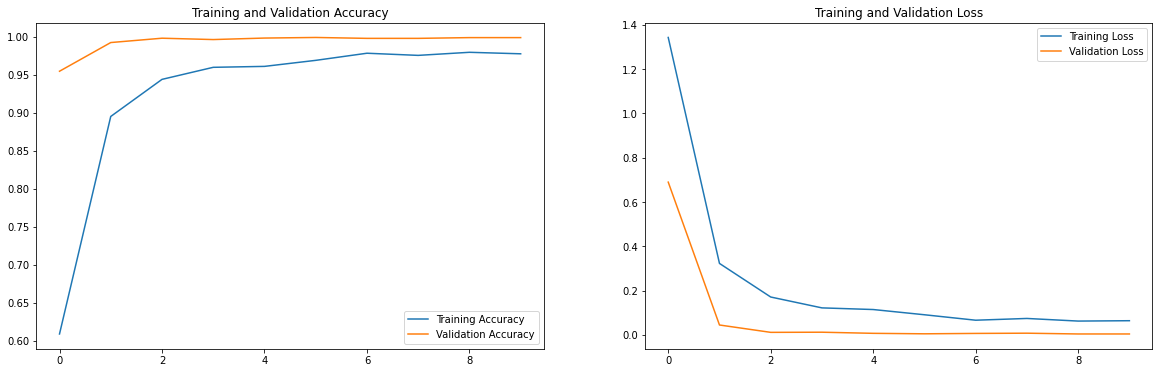

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### evaluate

In [24]:
model = results[0][0]

In [25]:
model.evaluate(validation_dataset)

80/80 [==============================] - 1s 16ms/step - loss: 0.0039 - accuracy: 0.9988


[0.003857767442241311, 0.9988203048706055]

In [26]:
predict_val = model.predict(validation_dataset).argmax(axis=1)
predict_val.shape, validation_label.shape

((5086,), (5086,))

In [27]:
predict_val[40:46], validation_label[40:46]

(array([10,  0,  7, 10, 29,  7]), 40    10.0
 41     0.0
 42     7.0
 43    10.0
 44    29.0
 45     7.0
 Name: 0, dtype: float32)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
# import seaborn as sns
# sns.heatmap(confusion_matrix(validation_label, predict_val), annot=True)

In [30]:
#Accuracy of the predicted values
print(classification_report(validation_label, predict_val)) 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       201
         1.0       1.00      1.00      1.00       201
         2.0       1.00      1.00      1.00       182
         3.0       1.00      1.00      1.00       140
         4.0       1.00      1.00      1.00       193
         5.0       1.00      0.99      1.00       198
         6.0       1.00      1.00      1.00       103
         7.0       1.00      1.00      1.00       207
         8.0       1.00      0.99      0.99       199
         9.0       0.99      1.00      1.00       151
        10.0       1.00      1.00      1.00       190
        11.0       1.00      1.00      1.00       182
        12.0       1.00      1.00      1.00       165
        13.0       1.00      1.00      1.00       196
        14.0       1.00      1.00      1.00       170
        15.0       1.00      1.00      1.00       142
        16.0       0.99      1.00      1.00       188
        17.0       1.00    